# CZ3006 Net Centric Computing Lab 3

# Analyzing net traffic log data

**Teo Chen Ning / U1820456K**

In [30]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os

In [31]:
# Load data with headers
DATA_PATH = "..\\data\\sflow_data.csv"

df = pd.read_csv(DATA_PATH, names=["type", "sflow_agent_address", "input_port", "output_port", "src_mac", "dest_mac", "ethernet_type", "in_vlan", "out_vlan", "src_ip", "dest_ip", "ip_protocol", "ip_tos", "ip_ttl", "src_port", "dest_port", "tcp_flags", "packet_size", "ip_size", "sampling_rate"])

df.head()

,type,sflow_agent_address,input_port,output_port,src_mac,dest_mac,ethernet_type,in_vlan,out_vlan,src_ip,dest_ip,ip_protocol,ip_tos,ip_ttl,src_port,dest_port,tcp_flags,packet_size,ip_size,sampling_rate
0,FLOW,203.30.38.251,129,193,00135f21bc80,0031466b23cf,0x0800,11.0,919,155.69.160.77,74.125.130.141,6,0x60,59,57577.0,443,0x10,74,52,2048
1,FLOW,203.30.38.251,129,193,00135f21bc80,0031466b23cf,0x0800,11.0,919,155.69.160.78,74.125.203.128,6,0x00,59,34809.0,443,0x10,1442,1420,2048
2,FLOW,203.30.38.251,131,193,001cb0c88e40,0031466b23cf,0x0800,43.0,919,192.122.131.134,74.125.10.12,6,0x00,57,50549.0,443,0x10,102,80,2048
3,FLOW,203.30.38.251,135,129,002688cd5fc7,00135f21bc80,0x0800,919.0,11,54.169.229.179,155.69.191.254,17,0x00,57,16285.0,39641,0x10,580,562,2048
4,FLOW,203.30.38.251,193,130,0031466b23cf,00239cd087c1,0x0800,919.0,919,209.85.229.247,137.132.228.34,17,0x00,63,443.0,32817,0x00,1396,1378,2048


### Find the top 5 talkers (i.e. sender nodes)
To do this, we get the top 5 highest occurances for the attribute ```src_ip```.

In [32]:
# EXERCISE 3A: Find top 5 talkers (i.e. sender nodes)
top_5_talkers = df['src_ip'].value_counts()[:5]

print("{:<18}{:<9}".format("Sender IP", "Count"))
for talker in top_5_talkers.keys():
    print("{:<18}{:<9}".format(talker, top_5_talkers[talker]))

Sender IP         Count    
103.26.47.233     9646     
13.107.4.50       4950     
155.69.160.78     4563     
130.14.250.7      3914     
173.194.22.215    2896     


### Find the top 5 listeners (i.e. receiving nodes)
To do this, we get the top 5 highest occurances for the attribute ```dest_ip```.

In [33]:
# EXERCISE 3A: Find top 5 listeners (i.e. receiving nodes)
top_5_listeners = df['dest_ip'].value_counts()[:5]

print("{:<18}{:<9}".format("Listener IP", "Count"))
for listener in top_5_listeners.keys():
    print("{:<18}{:<9}".format(listener, top_5_listeners[listener]))

Listener IP       Count    
103.22.221.73     9646     
137.132.228.33    7835     
137.132.228.29    5964     
137.132.228.42    4987     
103.37.198.100    3915     


### Find the proportions of TCP and UDP packets
Get the counts of each protocol used via ```ip_protocol```.

Protocol   Count    Proportion
6          155799   76.37%
17         45377    22.24%
0          1218     0.60% 
47         891      0.44% 
50         643      0.32% 


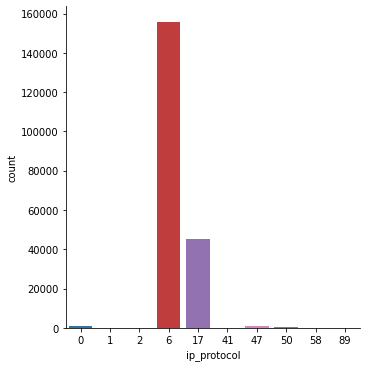

In [34]:
# EXERCISE 3B: Find the proportions of TCP and UDP packets
sns.catplot(x="ip_protocol", kind="count", data=df)

top_5_protocols = df['ip_protocol'].value_counts()[:5]

total_count = len(df.index)

print("{:<11}{:<9}{:<6}".format("Protocol", "Count", "Proportion"))
for protocol in top_5_protocols.keys():
    print("{:<11d}{:<9}{:<6.2%}".format(protocol, top_5_protocols[protocol], top_5_protocols[protocol]/total_count))

### Find the top 5 applications
To do this, we get the top 5 highest occurances for the attribute ```dest_port```.

In [35]:
# EXERCISE 3C: Find the top 5 application protocols
top_5_apps = df['dest_port'].value_counts()[:5]

print("{:<20}{:<9}".format("Application Port", "Count"))
for app in top_5_apps.keys():
    print("{:<20}{:<9}".format(app, top_5_apps[app]))

Application Port    Count    
443                 42975    
80                  11960    
56800               3918     
15000               2697     
44678               1158     


### Find the total traffic
To do this, sum the attribute ```ip_size``` and multiply by the sampling rate (Assume 1 in 1000).

In [8]:
# EXERCISE 3D: Find the total traffic intensity
total_traffic_bytes = df['ip_size'].sum() * 1000
total_traffic_mb_binary = total_traffic_bytes / (2**20)
total_traffic_mb_decimal = total_traffic_bytes / (10**6)

print("Total Traffic")
print("{:<16}{:<21}{:<21}".format("Bytes", "Megabytes (Binary)", "Megabytes (Decimal)"))
print("{:<16}{:<21.2f}{:<21.2f}".format(total_traffic_bytes, total_traffic_mb_binary, total_traffic_mb_decimal))

Total Traffic
Bytes           Megabytes (Binary)   Megabytes (Decimal)  
199163627000    189937.24            199163.63            


---
# Additional analysis

### Find the top 5 communication pairs (optional)
To do this, we group pairs of ```src_ip``` and ```dest_ip``` together, and find the count of the pairs.

In [9]:
# Additional analysis
# EXERCISE 3E: Find the top 5 communication pairs (optional)
df_comm_pairs = df
df_comm_pairs['ip_pair'] = None

for index, row in df_comm_pairs.iterrows():
    ip_pair_list = []
    ip_pair_list.append(row['src_ip'])
    ip_pair_list.append(row['dest_ip'])
    ip_pair_list.sort()
    ip_pair_tuple = tuple(ip_pair_list)
    df_comm_pairs.at[index, 'ip_pair'] = ip_pair_tuple

df_comm_grouped = df.groupby('ip_pair').size().reset_index(name='count')
df_comm_grouped = df_comm_grouped.sort_values(['count'], ascending=False)
top_5_comm_pairs = df_comm_grouped.head(5)

print("{:<18}{:<18}{}".format("IP 1", "IP 2", "Count"))
for index, row in top_5_comm_pairs.iterrows():
    print("{:<18}{:<18}{}".format(row['ip_pair'][0], row['ip_pair'][1], row['count']))

IP 1              IP 2              Count
103.22.221.73     103.26.47.233     11092
104.44.201.147    202.21.159.244    4608
103.37.198.100    130.14.250.7      4358
129.99.230.54     137.132.22.74     3203
128.117.28.212    155.69.52.27      1572


### Visualize the communication between different IP hosts (optional)
To do this, we create a directed network graph where each node is an IP having ```src_ip``` -> ```dest_ip```.

src_ip: 103.26.47.233


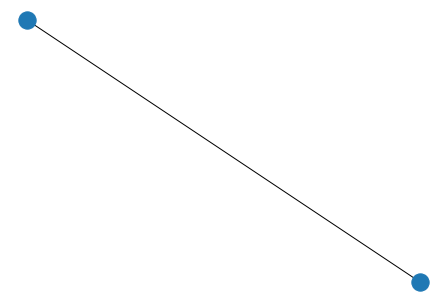

src_ip: 13.107.4.50


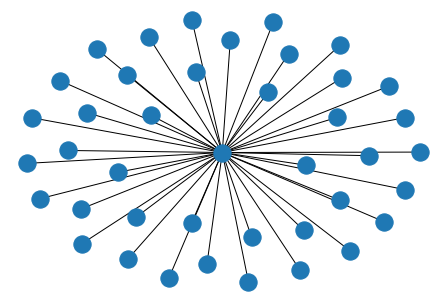

src_ip: 155.69.160.78


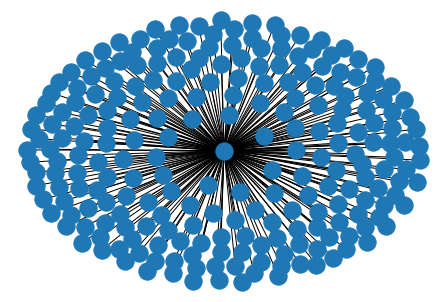

src_ip: 130.14.250.7


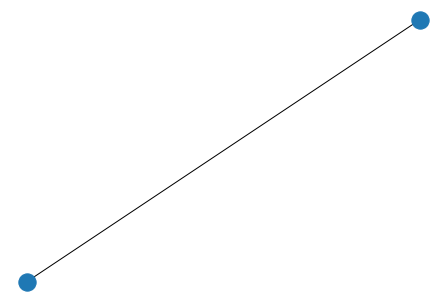

src_ip: 173.194.22.215


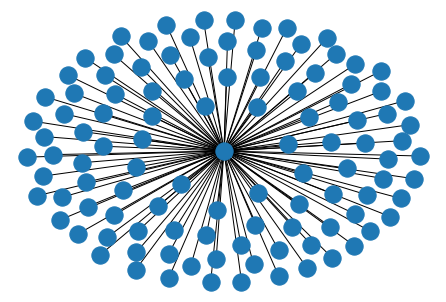

In [36]:
# EXERCISE 3E: Visualize the communication between different IP hosts (optional)
for talker in top_5_talkers.keys():
    df_network = df.loc[df['src_ip'] == talker]
    df_network = df_network[['src_ip', 'dest_ip']]
    print("src_ip:", talker)

    network_graph = nx.Graph()
    network_graph = nx.from_pandas_edgelist(df_network, 'src_ip', 'dest_ip')
    nx.draw(network_graph, with_labels=False)
    plt.show()

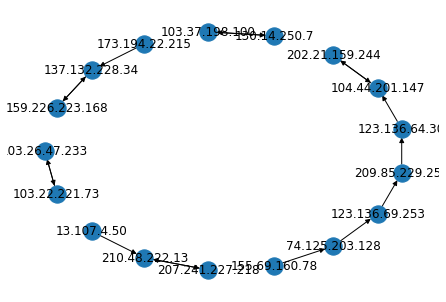

In [43]:
# EXERCISE 3E: Visualize the communication between different IP hosts (optional)
src = '155.69.160.78'
dest = ''

network_graph = nx.DiGraph()

for talker in top_5_talkers.keys():
    src = talker
    for i in range(10):
        df_network = df.loc[df['src_ip'] == src][:1]
        df_network = df_network[['src_ip', 'dest_ip']]
        src = df_network[['src_ip']].values[0][0]
        dest = df_network[['dest_ip']].values[0][0]
        network_graph.add_edge(src, dest)
        src = dest

nx.draw_shell(network_graph, with_labels=True)